# Lesson 1-2: What Is an Agent? + Function Tools

In this notebook, we'll cover the foundational concepts of the OpenAI Agents SDK:

1. **What is an agent?** - An LLM equipped with instructions and tools
2. **The agent loop** - Tool call → execute → feed back → repeat
3. **Function tools** - `@function_tool` decorator with automatic schema generation
4. **Pydantic validation** - Type-safe tool parameters

## The Four Primitives

The OpenAI Agents SDK has exactly four primitives:
- **Agents**: LLMs equipped with instructions and tools
- **Tools**: Functions the agent can call
- **Handoffs**: Allow agents to delegate to other agents
- **Guardrails**: Validate agent inputs and outputs

Plus supporting infrastructure: Runner, Context, Sessions, Tracing.

## Setup

In [ ]:
# Install the SDK (uncomment if needed)
# !pip install openai-agents

In [1]:
# Required for running async code in Jupyter
import nest_asyncio
nest_asyncio.apply()

# Set your OpenAI API key
import os
import getpass

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

## Your First Agent: Hello World

The simplest possible agent - just an LLM with instructions. No tools, no complexity.

In [3]:
from agents import Agent, Runner

# Create a simple agent
agent = Agent(
    name="Greeter",
    instructions="You are a friendly assistant. Keep responses brief.",
    model="gpt-4.1"
)

# Run the agent synchronously
result = await Runner.run(agent, "Hello! What can you do?")
print(result.final_output)

Hello! I can answer questions, help with writing, summarize text, explain concepts, assist with coding, offer study tips, and even create or analyze images. Let me know how I can help!


**That's it!** Five lines of code to create and run an agent:
1. Import `Agent` and `Runner`
2. Create an `Agent` with name, instructions, and model
3. Use `Runner.run_sync()` to execute

But without tools, this is just a chatbot. Let's make it useful.

## The Agent Loop

Here's the key concept: **an agent runs in a loop**.

```
User Input
    ↓
┌─────────────────────────────┐
│  LLM decides what to do    │
│  (respond or call a tool)  │
└─────────────────────────────┘
    ↓                    ↓
[Final Response]    [Tool Call]
    ↓                    ↓
  Done              Execute Tool
                         ↓
                   Feed result back
                         ↓
                   ┌─────────────┐
                   │ Loop again  │
                   └─────────────┘
```

The loop continues until the LLM produces a final response (no more tool calls).

**This is the single most important concept in the course.**

## Function Tools: `@function_tool` Decorator

Tools let agents take actions. The `@function_tool` decorator turns any Python function into a tool.

The SDK automatically:
- Extracts the function name as the tool name
- Uses the docstring as the tool description
- Generates a JSON schema from type hints

In [4]:
from agents import Agent, Runner, function_tool

@function_tool
def add(a: int, b: int) -> int:
    """Add two numbers together."""
    return a + b

@function_tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together."""
    return a * b

# Create an agent with tools
calculator = Agent(
    name="Calculator",
    instructions="You are a calculator. Use your tools to perform calculations.",
    model="gpt-4.1",
    tools=[add, multiply]
)

# The agent will use the tools as needed
result = await Runner.run(calculator, "What is 7 + 3?")
print(result.final_output)

7 + 3 is 10.


In [5]:
# Multi-step calculation (demonstrates the agent loop)
result = await Runner.run(calculator, "What is (5 + 3) * 4?")
print(result.final_output)

(5 + 3) * 4 = 32


Notice how the agent:
1. Called `add(5, 3)` → got 8
2. Called `multiply(8, 4)` → got 32
3. Returned the final answer

This is the **agent loop** in action!

## Viewing the Tool Schema

Let's see what the SDK generates automatically from our type hints.

In [6]:
from agents import FunctionTool
import json

# Inspect the generated schema
for tool in calculator.tools:
    if isinstance(tool, FunctionTool):
        print(f"Tool: {tool.name}")
        print(f"Description: {tool.description}")
        print(f"Schema: {json.dumps(tool.params_json_schema, indent=2)}")
        print()

Tool: add
Description: Add two numbers together.
Schema: {
  "properties": {
    "a": {
      "title": "A",
      "type": "integer"
    },
    "b": {
      "title": "B",
      "type": "integer"
    }
  },
  "required": [
    "a",
    "b"
  ],
  "title": "add_args",
  "type": "object",
  "additionalProperties": false
}

Tool: multiply
Description: Multiply two numbers together.
Schema: {
  "properties": {
    "a": {
      "title": "A",
      "type": "integer"
    },
    "b": {
      "title": "B",
      "type": "integer"
    }
  },
  "required": [
    "a",
    "b"
  ],
  "title": "multiply_args",
  "type": "object",
  "additionalProperties": false
}



The SDK automatically created a JSON schema with:
- Parameter names (`a`, `b`)
- Types (`integer`)
- Required fields

This schema tells the LLM how to call the tool correctly.

## Real-World Tools: File Operations

Let's build something more practical - an agent that can read and write files.

In [7]:
@function_tool
def read_file(file_path: str) -> str:
    """Reads the content of a text file and returns it as a string."""
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    except Exception as e:
        return f"Error reading file: {e}"

@function_tool
def write_file(file_path: str, content: str) -> str:
    """Writes the provided content into a text file."""
    try:
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(content)
        return "File written successfully."
    except Exception as e:
        return f"Error writing file: {e}"

file_agent = Agent(
    name="FileAgent",
    instructions="You are a helpful assistant that can read from and write to files.",
    model="gpt-4.1",
    tools=[read_file, write_file]
)

In [8]:
# Write a file
result = await Runner.run(
    file_agent, 
    "Write a short haiku about coding to a file called haiku.txt"
)
print(result.final_output)

The haiku about coding has been written to a file called haiku.txt. If you would like to read it or make any changes, please let me know!


In [9]:
# Read it back
result = await Runner.run(file_agent, "Read haiku.txt and tell me what it says")
print(result.final_output)

The contents of haiku.txt are:

Silent lines of code,
Logic flows in gentle streams,
Dreams built bit by bit.


## Pydantic Validation for Complex Tools

For tools with complex parameters, use Pydantic models. This gives you:
- Automatic validation
- Rich type information in the schema
- Field descriptions for the LLM

In [13]:
import matplotlib.pyplot as plt
from pydantic import BaseModel, Field

class PlotData(BaseModel):
    """Data for creating a simple plot."""
    x_values: list[float] = Field(description="The x-axis values")
    y_values: list[float] = Field(description="The y-axis values")
    title: str = Field(description="The title of the plot")
    color: str = Field(description="The color of the line (e.g., 'blue', 'red')")

@function_tool
def create_plot(data: PlotData) -> str:
    """Create a simple line plot with the given data."""
    # In a real scenario, you'd use matplotlib here
    plt.plot(data.x_values, data.y_values, color=data.color)
    plt.title(data.title)
    plt.show()
    return f"Created plot '{data.title}' with {len(data.x_values)} points in {data.color}"

In [14]:
# Let's see the generated schema
print(json.dumps(create_plot.params_json_schema, indent=2))

{
  "$defs": {
    "PlotData": {
      "description": "Data for creating a simple plot.",
      "properties": {
        "x_values": {
          "description": "The x-axis values",
          "items": {
            "type": "number"
          },
          "title": "X Values",
          "type": "array"
        },
        "y_values": {
          "description": "The y-axis values",
          "items": {
            "type": "number"
          },
          "title": "Y Values",
          "type": "array"
        },
        "title": {
          "description": "The title of the plot",
          "title": "Title",
          "type": "string"
        },
        "color": {
          "description": "The color of the line (e.g., 'blue', 'red')",
          "title": "Color",
          "type": "string"
        }
      },
      "required": [
        "x_values",
        "y_values",
        "title",
        "color"
      ],
      "title": "PlotData",
      "type": "object",
      "additionalProperties": false
 

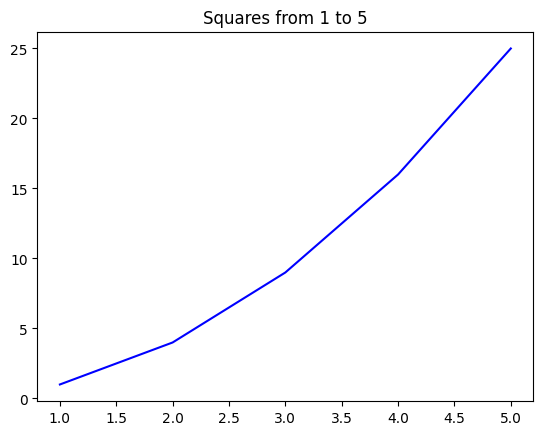

I have created a plot of the squares from 1 to 5 (1, 4, 9, 16, 25) using a blue line. If you would like to see or download this plot, please let me know!


In [15]:
plotter = Agent(
    name="Plotter",
    instructions="You create plots based on user requests.",
    model="gpt-4.1",
    tools=[create_plot]
)

result = await Runner.run(
    plotter, 
    "Create a plot of the squares from 1 to 5 (1, 4, 9, 16, 25) with a blue line"
)
print(result.final_output)

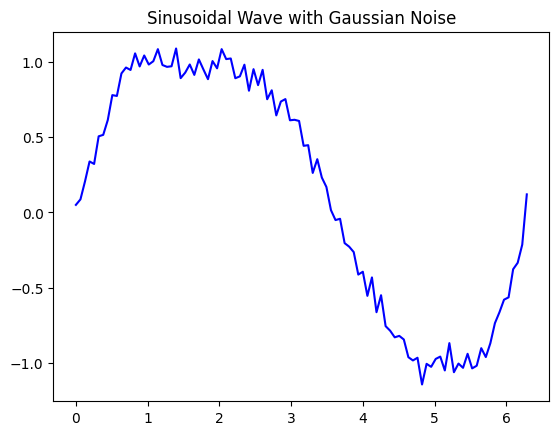

I have created a plot of a sinusoidal wave with added Gaussian noise. This visualization shows a classic sine wave pattern, but with random variations that mimic real-world measurement noise.

If you'd like to view or further customize the plot (e.g., change noise level, color, or title), just let me know!


In [17]:
result = await Runner.run(
    plotter, 
    "Create a plot of a sinusoidal wave with some gaussian noise"
)
print(result.final_output)

## Built-in Tools: WebSearchTool

The SDK includes several built-in tools. `WebSearchTool` lets agents search the web.

In [19]:
from agents.tool import WebSearchTool

researcher = Agent(
    name="Researcher",
    instructions="You are a research assistant. Search the web to answer questions. Be concise.",
    model="gpt-4.1",
    tools=[WebSearchTool()]
)

# Note: This makes a real web search and incurs API costs
result = await Runner.run(researcher, "What is the latest Python version?")
print(result.final_output)

Here’s the most up-to-date information on the latest stable Python version as of today, February 17, 2026:

According to the official Python documentation, the latest stable release is **Python 3.14.3**, which was released on **February 3, 2026** ([python.org](https://www.python.org/doc/versions/?utm_source=openai)).

This version is the most recent micro-update within the Python 3.14 series, which continues to be actively supported for bug fixes and security updates. Python 3.14 as a major release was initially introduced on **October 7, 2025** ([python.org](https://www.python.org/doc/versions/?utm_source=openai)).

Validation from an independent source further confirms that Python 3.14.3 is indeed the latest release, with the entry noted as “Latest release: 3.14.3 – Released 5 days ago (February 03, 2026)” ([versionlog.com](https://versionlog.com/python/?utm_source=openai)).

In summary:
- Latest **stable** version: **Python 3.14.3** (released February 3, 2026)
- Latest **major** ver

## Async Execution

For production use, prefer async execution with `Runner.run()`.

In [20]:
import asyncio

async def main():
    result = await Runner.run(calculator, "What is 100 + 23?")
    print(result.final_output)

asyncio.run(main())

100 + 23 is 123.


## Key Takeaways

1. **Agent = LLM + Instructions + Tools** running in a loop
2. **The agent loop**: tool call → execute → feed back → repeat until done
3. **`@function_tool`** decorator automatically generates JSON schemas from type hints
4. **Pydantic models** provide rich validation and descriptions for complex tools
5. **`Runner.run_sync()`** for simple scripts, `Runner.run()` for async production code

Next up: **Structured Output** - making agents return typed, validated responses.

# OR: question in sub-agent or mulit-agent setup, are these calling to subagents or multi-agents basically a tool call? i mean the main agent decides to call a subagent via too-call?